In [1]:
import pandas as pd
import datetime as dt

# SQLAlchemy
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

from sqlalchemy import Column, Integer, String, Float, Date, null, ForeignKey

In [2]:
# Create Movie and Rating classes and databases
# ----------------------------------
class Movie(Base):
    __tablename__ = 'movie'
    movie_id = Column(Integer, primary_key=True, autoincrement=False)
    adult = Column(String(10), nullable=True)
    budget = Column(Float, nullable=True)
    imdb_id = Column(String(40), nullable=True)
    language = Column(String(10), nullable=True)
    title = Column(String(512), nullable=True)
    popularity = Column(Float, nullable=True)
    release_date = Column(Date, nullable=True)
    revenue = Column(Float, nullable=True)
    runtime = Column(Float, nullable=True)
    status = Column(String(10), nullable=True)
    vote_average = Column(Float, nullable=True)
    vote_count = Column(Float, nullable=True)

class Rating(Base):
    __tablename__ = 'rating'
    id = Column(Integer, primary_key=True)
    movie_id = Column(Integer, ForeignKey("movie.movie_id")) #foriegn key
    user_id = Column(Integer)
    rating = Column(Float, nullable=True)

In [3]:
# Path to sqlite
database_path = "database/combined_data.sqlite"

# Create an engine that can talk to the database
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [4]:
# Use this to clear out the db
Base.metadata.drop_all(engine)

# Create a "Metadata" Layer That Abstracts our SQL Database
# ----------------------------------
Base.metadata.create_all(engine)

In [5]:
from sqlalchemy.orm import Session
session = Session(bind=engine)

In [6]:
#import the movies csv file into dataframe
file_movie = "files/movies_metadata.csv"

#columns to import from csv file .. 
col_list = ["adult", "budget", "id", "imdb_id", "original_language", "title", "release_date", "revenue", "runtime", "status", "vote_average", "vote_count", "popularity" ]
movies_df = pd.read_csv(file_movie,usecols=col_list, low_memory=False)
movies_df.head(5)

,adult,budget,id,imdb_id,original_language,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count
0,FALSE,0,2,tt0094675,fi,3.860491,10/21/1988,0.0,69.0,Released,Ariel,7.1,44.0
1,FALSE,0,3,tt0092149,fi,2.29211,10/16/1986,0.0,76.0,Released,Shadows in Paradise,7.1,35.0
2,FALSE,4000000,5,tt0113101,en,9.026586,12/9/1995,4300000.0,98.0,Released,Four Rooms,6.5,539.0
3,FALSE,0,6,tt0107286,en,5.538671,10/15/1993,12136938.0,110.0,Released,Judgment Night,6.4,79.0
4,FALSE,11000000,11,tt0076759,en,42.149697,5/25/1977,775398007.0,121.0,Released,Star Wars,8.1,6778.0


In [7]:
#remove duplicate id from dataframe
movies_df.drop_duplicates(subset='id', inplace=True)

#convert id to int and remove the non-numeric ids
movies_df[["id"]] = movies_df[["id"]].apply(pd.to_numeric, errors='coerce')

#remove null or na
movies_df.dropna(subset=['id'], inplace= True)

movies_df.head()
#movies_df.dtypes

,adult,budget,id,imdb_id,original_language,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count
0,FALSE,0,2.0,tt0094675,fi,3.860491,10/21/1988,0.0,69.0,Released,Ariel,7.1,44.0
1,FALSE,0,3.0,tt0092149,fi,2.29211,10/16/1986,0.0,76.0,Released,Shadows in Paradise,7.1,35.0
2,FALSE,4000000,5.0,tt0113101,en,9.026586,12/9/1995,4300000.0,98.0,Released,Four Rooms,6.5,539.0
3,FALSE,0,6.0,tt0107286,en,5.538671,10/15/1993,12136938.0,110.0,Released,Judgment Night,6.4,79.0
4,FALSE,11000000,11.0,tt0076759,en,42.149697,5/25/1977,775398007.0,121.0,Released,Star Wars,8.1,6778.0


In [8]:
#read each row from the dataframe and store in the movie table
print("Starting Movies Migration")
for index, row in movies_df.iterrows():
    release_dt = null()
    
    if not pd.isna(row["release_date"]): #check to see if the release_date is not null or not na
        try: #try/except to avoid error due to date converion from string
            release_dt = dt.datetime.strptime(row["release_date"], '%m/%d/%Y').date()
        #break
        except ValueError:
            release_dt = null()
            #print(f'error processing release_date {row["release_date"]}')

    #creating the movie object and adding it to the db session
    movie = Movie(movie_id=int(row["id"]), adult=row["adult"], status=row["status"], title=row["title"],  
                  language=row["original_language"], release_date=release_dt, imdb_id=row["imdb_id"],  
                  budget=float(row["budget"]), popularity=float(row["popularity"]), revenue=float(row["revenue"]), 
                  runtime=float(row["runtime"]), vote_average=float(row["vote_average"]), vote_count=float(row["vote_count"]))
    session.add(movie)
    
session.commit() #save the session
print("Finished Movies Migration")

Starting Movies Migration
Finished Movies Migration


In [17]:
#example query
movie_list = session.query(Movie)
for movie in movie_list:
    print(f'{movie.movie_id}' + " " + f'{movie.release_date.strftime("%m/%d/%Y")}')

2 10/21/1988
3 10/16/1986
5 12/09/1995
6 10/15/1993
11 05/25/1977
12 05/30/2003
13 07/06/1994
14 09/15/1999
15 04/30/1941
16 05/17/2000
17 01/26/2006
18 05/07/1997
19 01/10/1927
20 03/07/2003
21 06/15/1966
22 07/09/2003
24 10/10/2003
25 11/04/2005
26 02/05/2004
27 07/16/2004
28 08/15/1979
30 12/23/1995
33 08/07/1992
35 07/25/2007
38 03/19/2004
55 06/16/2000
58 06/20/2006
59 09/23/2005
62 04/10/1968
63 12/29/1995
64 03/14/2002
65 11/08/2002
66 02/14/1997
67 02/14/2005
68 02/20/1985
69 09/13/2005
70 12/15/2004
71 05/18/2000
73 10/30/1998
74 06/28/2005
75 12/12/1996
76 01/27/1995
77 10/11/2000
78 06/25/1982
79 12/19/2002
80 02/10/2004
81 03/11/1984
82 07/27/2006
83 08/06/2004
85 06/12/1981
86 02/10/2006
87 05/23/1984
88 08/21/1987
89 05/24/1989
90 11/29/1984
91 12/01/1933
92 08/12/1998
93 07/01/1959
95 07/01/1998
96 05/18/1987
97 07/09/1982
98 05/01/2000
99 04/19/1999
100 03/05/1998
101 09/14/1994
102 09/06/2002
103 02/07/1976
104 08/20/1998
105 07/03/1985
106 06/11/1987
107 09/01/2000
10

In [9]:
#example query

data = pd.read_sql("SELECT * FROM movie", conn)
data.head()

,movie_id,adult,budget,imdb_id,language,title,popularity,release_date,revenue,runtime,status,vote_average,vote_count
0,2,FALSE,0.0,tt0094675,fi,Ariel,3.860491,1988-10-21,0.0,69.0,Released,7.1,44.0
1,3,FALSE,0.0,tt0092149,fi,Shadows in Paradise,2.292110,1986-10-16,0.0,76.0,Released,7.1,35.0
2,5,FALSE,4000000.0,tt0113101,en,Four Rooms,9.026586,1995-12-09,4300000.0,98.0,Released,6.5,539.0
3,6,FALSE,0.0,tt0107286,en,Judgment Night,5.538671,1993-10-15,12136938.0,110.0,Released,6.4,79.0
4,11,FALSE,11000000.0,tt0076759,en,Star Wars,42.149697,1977-05-25,775398007.0,121.0,Released,8.1,6778.0


In [11]:
#import the ratings csv file into dataframe

file_ratings = "files/ratings.csv"
ratings_df = pd.read_csv(file_ratings, low_memory=False)
ratings_df.head(5)
#ratings_df.dtypes

,userId,movieId,rating,timestamp
0,7.0,1.0,3.0,8.518667e+08
1,9.0,1.0,4.0,9.386292e+08
2,13.0,1.0,5.0,1.331380e+09
3,15.0,1.0,2.0,9.979383e+08
4,19.0,1.0,3.0,8.551901e+08


In [12]:
#read each row from the dataframe and store in the rating table

print("Starting Ratings Migration")
for index, row in ratings_df.iterrows():
    try: #to avoid errors from converting na or null to int
        rating = Rating(movie_id=int(row["movieId"]), rating=row["rating"], user_id=row["userId"])
        session.add(rating)
    except ValueError:
        rating = null()
    
session.commit()
print("Finished Ratings Migration")

Starting Ratings Migration
Finished Ratings Migration


In [15]:
#number of times a movie has been rated
data = pd.read_sql("SELECT movie_id, count(*) as cnt FROM rating group by movie_id", conn)
data.head()

,movie_id,cnt
0,1,247
1,2,107
2,3,59
3,4,13
4,5,56


In [19]:
#average rating for each movie
data = pd.read_sql("SELECT movie_id, avg(rating) as average FROM rating group by movie_id", conn)
data.head()

,movie_id,avg
0,1,3.872470
1,2,3.401869
2,3,3.161017
3,4,2.384615
4,5,3.267857


In [20]:
#average rating for each user
data = pd.read_sql("SELECT user_id, avg(rating) as avg FROM rating group by user_id", conn)
data.head()

,user_id,avg
0,1,2.550000
1,2,3.486842
2,3,3.568627
3,4,4.348039
4,5,3.910000


In [22]:
#average rating for each movie
data = pd.read_sql("SELECT movie_id, avg(rating) as average FROM rating group by movie_id order by average desc ", conn)
data.head(100)

,movie_id,average
0,163949,5.0
1,162542,5.0
2,161944,5.0
3,160590,5.0
4,156025,5.0
...,...,...
95,83411,5.0
96,83359,5.0
97,83318,5.0
98,82608,5.0


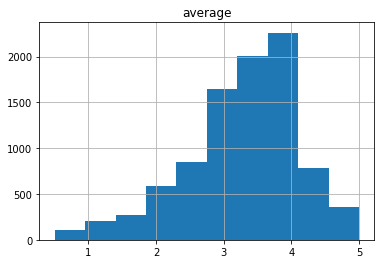

In [25]:
hist = data.hist("average")